In [1]:
import handcalcs.render

In [58]:
def B(arr, i, j, t):
    """
    Using De Casteljau's algorithm:
    Gets the one dimensional value of the coords at the provided i value
    Recurrence relation:
        B(i, j) = B(i, j - 1) * (1 - t) + B(i + 1, j - 1) * t
    """
    return arr[i] if j == 0 else B(arr, i, j - 1, t) * (1 - t) + B(arr, i + 1, j - 1, t) * t

In [1]:
%%latex
\begin{align}\beta _{i}^{{(0)}}:=\beta _{i}{\mbox{ , }}i=0,\ldots ,n\end{align}
\begin{align}\beta _{i}^{{(j)}}:=\beta _{i}^{{(j-1)}}(1-t_{0})+\beta _{{i+1}}^{{(j-1)}}t_{0}{\mbox{ , }}i=0,\ldots ,n-j{\mbox{ , }}j=1,\ldots ,n\end{align}

<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


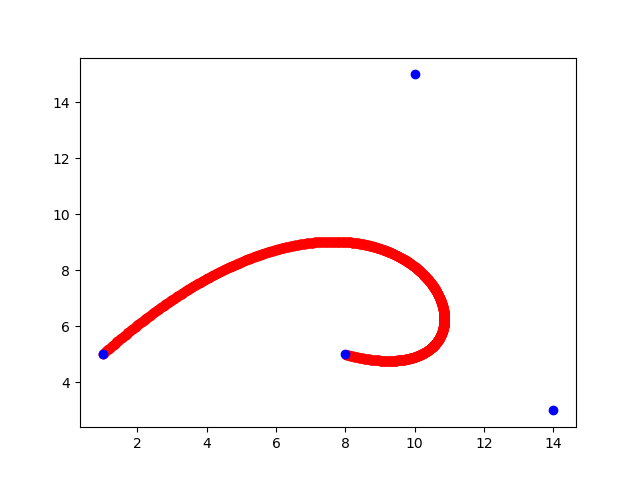

In [74]:
%matplotlib notebook
import matplotlib.pyplot as plt

control_x = [1, 10, 14, 8]
control_y = [5, 15, 3, 5]
n = len(control_x)
number_of_points = 1000
x_points = [B(control_x, 0, n - 1, t/number_of_points) for t in range(number_of_points)]
y_points = [B(control_y, 0, n - 1, t/number_of_points) for t in range(number_of_points)]

fig = plt.figure()
ax = plt.subplot(111)

for x, y in zip(x_points, y_points):
    plt.plot(x, y, marker="o", color="red")

for cx, cy in zip(control_x, control_y):
    plt.plot(cx, cy, marker="o", color="blue")

plt.show()